# DataLoader

압축푼 직후에는 파일적용이 되지 않아 FileNotFoundError 오류가 뜰 수 있습니다.

그러한 경우 약간의 대기 시간 이후 다시 실행하면 됩니다.

In [15]:
# 랜덤성 제어를 위한 seed 고정
import random
import numpy as np
import torch

seed = 0
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset
import torchvision.transforms as transforms
from torchvision.transforms import v2

from PIL import Image
from tqdm import tqdm
import pandas as pd

In [17]:
# 데이터셋 디렉토리 위치 지정
data_path = "/home/kim/Desktop/AI_project01_data/data"

In [18]:
from glob import glob

# 커스텀 데이터셋 클래스
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train
        train_df = pd.read_csv(f"{data_path}/train_data.csv")

        self.name2label = dict(zip(train_df["name"], train_df["label"]))

        if self.train:
            self.img_path = glob(f"{data_path}/train_data/*.png")
            self.labels =  [self.name2label[d.split("/")[-1]] for d in self.img_path]
        else:
            self.img_path = glob(f"{data_path}/test_data/*.png")

        self.transform = transform

        self.classes = {
            0: 'airplane',
            1: 'bird',
            2: 'car',
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'horse',
            7: 'monkey',
            8: 'ship',
            9: 'truck'
        }

    def __len__(self):
        return len(self.img_path)   

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.labels[index]
        else:
            return img, self.img_path[index].split("/")[-1]

In [19]:
'''
데이터 전처리
    - transform.Compose에 전처리할 순서를 차례로 지정한 후 리스트 형태로 입력하여 데이터 생성시 설정한 전처리를 적용
    - 여러 가지의 데이터 증강 기법이 들어감
'''
transform =  transforms.Compose([
    # To-do: 증강 기법 적용
    v2.RandomCrop(96, padding=4),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    v2.RandomErasing(scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
])

test_transform =  transforms.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_base = MyDataset(data_path, train=True, transform=transform)      # transform 적용
val_base   = MyDataset(data_path, train=True, transform=test_transform) # test_transform 적용
test_data = MyDataset(data_path, train=False, transform=test_transform)

# Split train data into train and validation
dataset_size = len(train_base)
train_size = int(dataset_size * 0.9)
val_size = dataset_size - train_size

train_subset, val_subset = torch.utils.data.random_split(range(dataset_size), [train_size, val_size])
train_data = Subset(train_base, train_subset.indices)
val_data   = Subset(val_base, val_subset.indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


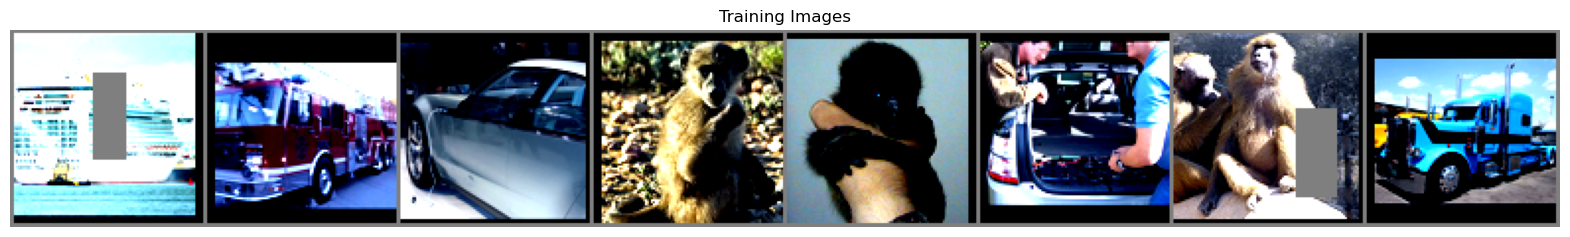

Labels: ['ship', 'truck', 'car', 'monkey', 'monkey', 'car', 'monkey', 'truck']


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 시각화용 역정규화 함수 (Normalize를 다시 되돌림)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# train_loader에서 배치를 하나 뽑아봅니다.
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 출력 (격자로 보기)
import torchvision
plt.figure(figsize=(20, 15))
plt.title('Training Images')
plt.grid(False)
plt.axis('off')

imshow(torchvision.utils.make_grid(images[:8], padding=2))
print('Labels:', [train_data.dataset.classes[l.item()] for l in labels[:8]])

# Model

In [21]:
from torchvision.models import resnet18
def get_model():
    model = resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 10)
    )
    return model
# Torchvision 라이브러리에서 모델 불러오기
model = get_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [23]:
from torchinfo import summary
summary(model, (1, 3, 96, 96), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 96, 96]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 96, 96]           128
├─ReLU: 1-3                              [1, 64, 96, 96]           --
├─Identity: 1-4                          [1, 64, 96, 96]           --
├─Sequential: 1-5                        [1, 64, 96, 96]           147,968
├─Sequential: 1-6                        [1, 128, 48, 48]          525,568
├─Sequential: 1-7                        [1, 256, 24, 24]          2,099,712
├─Sequential: 1-8                        [1, 512, 12, 12]          8,393,728
├─AdaptiveAvgPool2d: 1-9                 [1, 512, 1, 1]            --
├─Sequential: 1-10                       [1, 10]                   5,130
Total params: 11,173,962
Trainable params: 11,173,962
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 5.00
Input 

In [ ]:
import copy
criterion = nn.CrossEntropyLoss() # 바꿔보기
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # weight_decay 추가

# 학습률 스케줄러: 검증 손실이 개선되지 않으면 학습률 감소
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # 손실을 최소화
    factor=0.5,           # 학습률을 0.5배로 감소
    patience=10,          # 10 에포크 동안 개선 없으면 감소
)

num_epochs = 200 # 바꿔보기
patience = 20
best_correct = 0
epochs_no_improve = 0
best_model_state = None

total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train() #
    total_loss = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {round(total_loss / (i+1),4)}')


    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0 #
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item() * labels.size(0) #
        print(f'Accuracy of the model on the test images: {100 * correct / total} %')
    
    # ===================================================
    scheduler.step(val_loss / total) #


    # Early Stopping 체크
    if correct > best_correct:
        best_correct = correct
        epochs_no_improve = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1

    # Early Stopping
    if epochs_no_improve >= patience:
        print("=" * 90)
        print(f"Early Stopping at Epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"최고 성능 모델로 복원 (검증 정확도: {100 * best_correct / total} %)")

Epoch [1/200], Loss: 2.1515: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Accuracy of the model on the test images: 23.0 %


Epoch [2/200], Loss: 1.9009: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 33.0 %


Epoch [3/200], Loss: 1.8367: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 35.8 %


Epoch [4/200], Loss: 1.7608: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 38.2 %


Epoch [5/200], Loss: 1.7093: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 39.0 %


Epoch [6/200], Loss: 1.6197: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 42.4 %


Epoch [7/200], Loss: 1.5912: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 38.2 %


Epoch [8/200], Loss: 1.5488: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 46.0 %


Epoch [9/200], Loss: 1.5126: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 46.6 %


Epoch [10/200], Loss: 1.4902: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 52.2 %


Epoch [11/200], Loss: 1.4232: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 56.4 %


Epoch [12/200], Loss: 1.386: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s] 


Accuracy of the model on the test images: 53.0 %


Epoch [13/200], Loss: 1.3886: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s]


Accuracy of the model on the test images: 53.0 %


Epoch [14/200], Loss: 1.3601: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Accuracy of the model on the test images: 59.8 %


Epoch [15/200], Loss: 1.3131: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 58.8 %


Epoch [16/200], Loss: 1.2858: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 61.6 %


Epoch [17/200], Loss: 1.2639: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 49.2 %


Epoch [18/200], Loss: 1.254: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s] 


Accuracy of the model on the test images: 49.0 %


Epoch [19/200], Loss: 1.2366: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 56.2 %


Epoch [20/200], Loss: 1.2246: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Accuracy of the model on the test images: 65.0 %


Epoch [21/200], Loss: 1.1875: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 59.4 %


Epoch [22/200], Loss: 1.1762: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 68.8 %


Epoch [23/200], Loss: 1.1702: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s]


Accuracy of the model on the test images: 56.2 %


Epoch [24/200], Loss: 1.187: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s] 


Accuracy of the model on the test images: 60.8 %


Epoch [25/200], Loss: 1.14: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]  


Accuracy of the model on the test images: 65.8 %


Epoch [26/200], Loss: 1.1523: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]


Accuracy of the model on the test images: 61.2 %


Epoch [27/200], Loss: 1.1358: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 63.8 %


Epoch [28/200], Loss: 1.1109: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Accuracy of the model on the test images: 67.4 %


Epoch [29/200], Loss: 1.0796: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 56.8 %


Epoch [30/200], Loss: 1.0702: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 66.2 %


Epoch [31/200], Loss: 1.0837: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 54.6 %


Epoch [32/200], Loss: 1.0781: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 60.0 %


Epoch [33/200], Loss: 1.0488: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 57.8 %


Epoch [34/200], Loss: 0.9962: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 74.8 %


Epoch [35/200], Loss: 0.9514: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 76.0 %


Epoch [36/200], Loss: 0.9275: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 75.6 %


Epoch [37/200], Loss: 0.9189: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 68.6 %


Epoch [38/200], Loss: 0.9075: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 69.0 %


Epoch [39/200], Loss: 0.8846: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 60.0 %


Epoch [40/200], Loss: 0.9028: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 73.0 %


Epoch [41/200], Loss: 0.8743: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 71.8 %


Epoch [42/200], Loss: 0.8876: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 71.6 %


Epoch [43/200], Loss: 0.8872: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Accuracy of the model on the test images: 67.4 %


Epoch [44/200], Loss: 0.8679: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 75.8 %


Epoch [45/200], Loss: 0.8468: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]


Accuracy of the model on the test images: 71.0 %


Epoch [46/200], Loss: 0.79: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]  


Accuracy of the model on the test images: 73.4 %


Epoch [47/200], Loss: 0.7668: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 76.6 %


Epoch [48/200], Loss: 0.7574: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 77.8 %


Epoch [49/200], Loss: 0.7568: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 77.8 %


Epoch [50/200], Loss: 0.7521: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 77.8 %


Epoch [51/200], Loss: 0.7378: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 75.0 %


Epoch [52/200], Loss: 0.7395: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 76.8 %


Epoch [53/200], Loss: 0.7409: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 75.8 %


Epoch [54/200], Loss: 0.757: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s] 


Accuracy of the model on the test images: 74.6 %


Epoch [55/200], Loss: 0.7325: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 73.2 %


Epoch [56/200], Loss: 0.7134: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 76.0 %


Epoch [57/200], Loss: 0.7015: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 76.6 %


Epoch [58/200], Loss: 0.7119: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 77.6 %


Epoch [59/200], Loss: 0.7011: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 75.0 %


Epoch [60/200], Loss: 0.7114: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 80.0 %


Epoch [61/200], Loss: 0.6909: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


Accuracy of the model on the test images: 78.2 %


Epoch [62/200], Loss: 0.6766: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 78.6 %


Epoch [63/200], Loss: 0.6819: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 73.4 %


Epoch [64/200], Loss: 0.699: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s] 


Accuracy of the model on the test images: 76.0 %


Epoch [65/200], Loss: 0.6878: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 74.0 %


Epoch [66/200], Loss: 0.6635: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Accuracy of the model on the test images: 74.4 %


Epoch [67/200], Loss: 0.6762: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]


Accuracy of the model on the test images: 76.8 %


Epoch [68/200], Loss: 0.6729: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 77.6 %


Epoch [69/200], Loss: 0.6602: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]


Accuracy of the model on the test images: 77.6 %


Epoch [70/200], Loss: 0.658: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s] 


Accuracy of the model on the test images: 77.6 %


Epoch [71/200], Loss: 0.6544: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 76.6 %


Epoch [72/200], Loss: 0.6345: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 75.6 %


Epoch [73/200], Loss: 0.6338: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 77.2 %


Epoch [74/200], Loss: 0.6365: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 77.0 %


Epoch [75/200], Loss: 0.6375: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 75.8 %


Epoch [76/200], Loss: 0.6427: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 71.0 %


Epoch [77/200], Loss: 0.6366: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


Accuracy of the model on the test images: 78.4 %


Epoch [78/200], Loss: 0.6336: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Accuracy of the model on the test images: 77.4 %


Epoch [79/200], Loss: 0.6336: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]


Accuracy of the model on the test images: 76.4 %


Epoch [80/200], Loss: 0.61: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]  


Accuracy of the model on the test images: 80.0 %
Early Stopping at Epoch 80
최고 성능 모델로 복원 (검증 정확도: 80.0 %)


# Evaluation (Test)

In [25]:
len(val_loader.dataset)
len(test_loader.dataset)

8000

In [26]:
correct = 0
total = len(val_loader.dataset)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += torch.sum((predicted == labels)).item()

print(f'Accuracy : {100 * correct / total} %')


Accuracy : 80.0 %


# Make SubmitFile

In [27]:
import pandas as pd

# 제출 파일 submission.csv 생성
outputs = {
    'Id': [],
    'Prediction': []
}

for images, id in tqdm(test_loader):
    model.eval()
    with torch.no_grad():
        output = model(images.to(device))
        _, predicted = torch.max(output, 1)
        outputs['Prediction'] += predicted.tolist()
        outputs['Id'] += id

df = pd.DataFrame(outputs)

df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])

100%|██████████| 63/63 [00:10<00:00,  6.19it/s]


In [28]:
# 제출파일 다운로드
# from google.colab import files

# file_path = "submission.csv"
# files.download(file_path)